In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import missingno as msno

from scipy.stats import spearmanr, shapiro, pearsonr, ttest_ind, mannwhitneyu, chi2_contingency, kruskal, f_oneway

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import OneHotEncoder

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Заполнение пропусков и предобработка

In [6]:
df = pd.read_csv('raw_data.csv', skipinitialspace=True, sep=';')
df.rename(columns=lambda x: x.lower().replace(' ', '_'), inplace=True)
df.rename(columns={'скорость_воздуха': 'скорость_воздуха_снаружи'}, inplace=True)
df['год'] = df['год'].astype(int).astype(str)
df.head()

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,скорость_воздуха_снаружи,рост,вес,занавески,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций
0,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,22.0,NaN,...,0.26,NaN,NaN,1.0,1.0,NaN,NaN,NaN,28.9,0
1,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,40.0,NaN,...,0.12,NaN,NaN,0.0,0.0,NaN,NaN,NaN,84.0,0
2,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,42.0,NaN,...,0.08,NaN,NaN,0.0,0.0,NaN,NaN,NaN,32.8,0
3,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,27.0,NaN,...,27.16,NaN,NaN,1.0,1.0,NaN,NaN,NaN,28.9,1
4,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,46.0,NaN,...,63.83,NaN,NaN,1.0,1.0,NaN,NaN,NaN,32.8,0


План действий для предобработки:
*   Посмотреть количество и долю пропусков
*   Проверка данных на дубликаты и опечатки
*   Посмотреть соотношение вариантов ответа в количественных и категориальных столбцах
*   Проверка на выбросы и их обработка


In [7]:
#первичная проверка данных
def check_data(data_df):
    print('\033[1m' + 'Изучим исходные данные' + '\033[0m')
    print(data_df.info())
    print(data_df.shape) #(строки, столбцы)

    missed_cells = data_df.isnull().sum().sum() / (data_df.shape[0] * (data_df.shape[1] - 1)) #ячейки
    missed_rows = sum(data_df.isnull().sum(axis = 1) > 0) / data_df.shape[0]
    print('\033[1m' + '\nПроверка пропусков' + '\033[0m')
    print('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
    print('Доля пропусков: {:.1%}'.format(missed_cells) + '\033[0m')
    print("Доля строк, содержащих пропуски: {:.1%}".format(missed_rows))

    #Проверка дубликатов
    print('\033[1m' + '\nПроверка на дубликаты' + '\033[0m')
    print('Количество полных дубликатов: ', data_df.duplicated().sum())

    print('\033[1m' + '\nОписание количественных строк' + '\033[0m')
    print(data_df.describe().T)

    print('\033[1m' + '\nОписание категориальных строк' + '\033[0m')
    print(data_df.describe(include='object').T)

    print('\033[1m' + '\nВывод уникальных значений по каждому категориальному признаку' + '\033[0m')
    df_object = data_df.select_dtypes(include='object').columns

    for i in df_object:
        print('\033[1m' + '_' + str(i) + '\033[0m')
        print(data_df[i].value_counts())

check_data(df)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 30 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   год                                          484 non-null    object 
 1   время_года                                   484 non-null    object 
 2   климат                                       484 non-null    object 
 3   город                                        484 non-null    object 
 4   страна                                       484 non-null    object 
 5   способ_охлаждения                            484 non-null    object 
 6   режим_при_смешанном_типе_охлаждения          337 non-null    object 
 7   способ_обогрева                              222 non-null    object 
 8   возраст                                      413 non-null    float64
 9   пол                                          412 non-

В столбцах "климат" и "предпочтительное_изменение_температуры" есть опечатки. Очень много пропусков.

In [8]:
# обработка опечаток и пропусков, которые являются значениями
df['предпочтительное_изменение_температуры'].replace(['Холодн', 'Тепле'], ['Холоднее', 'Теплее'], inplace=True)
df['климат'].replace('Субтроп океанич', 'Cубтропический океанический', inplace=True)
df['режим_при_смешанном_типе_охлаждения'] = df['режим_при_смешанном_типе_охлаждения'].fillna('нет')
df['способ_обогрева'] = df['способ_обогрева'].fillna('нет')

# удаление дубликата
df = df.drop_duplicates()

In [4]:
def plot_hist(data, col_column):
    rows = len(col_column)
    fgsz = None
    if rows == 1: fgsz = (10, 5)
    else: fgsz = (8, 15)
    f, ax = plt.subplots(rows, 2, figsize=fgsz)
    f.tight_layout()
    # f.set_figheight(30)
    # f.set_figwidth(14)
    plt.rcParams.update({'font.size': 11})

    if rows == 1:
        col = col_column[0]
        sns.histplot(data[col], kde=True, bins=24, ax=ax[0])
        sns.boxplot(data[col], ax=ax[1])

        ax[0].set_xlabel(col)
        ax[1].set_xlabel(col)
        ax[0].set_ylabel('Количество')
    else:
        for i, col in enumerate(col_column):
            sns.histplot(data[col], kde=True, bins=24, ax=ax[i, 0])
            sns.boxplot(data[col], ax=ax[i, 1])

            ax[i, 0].set_xlabel(col)
            ax[i, 1].set_xlabel(col)
            ax[i, 0].set_ylabel('Количество')
    plt.suptitle("Гистограмма и ящик с усами для количественных данных", fontsize=22, y=1.01)
    plt.show()

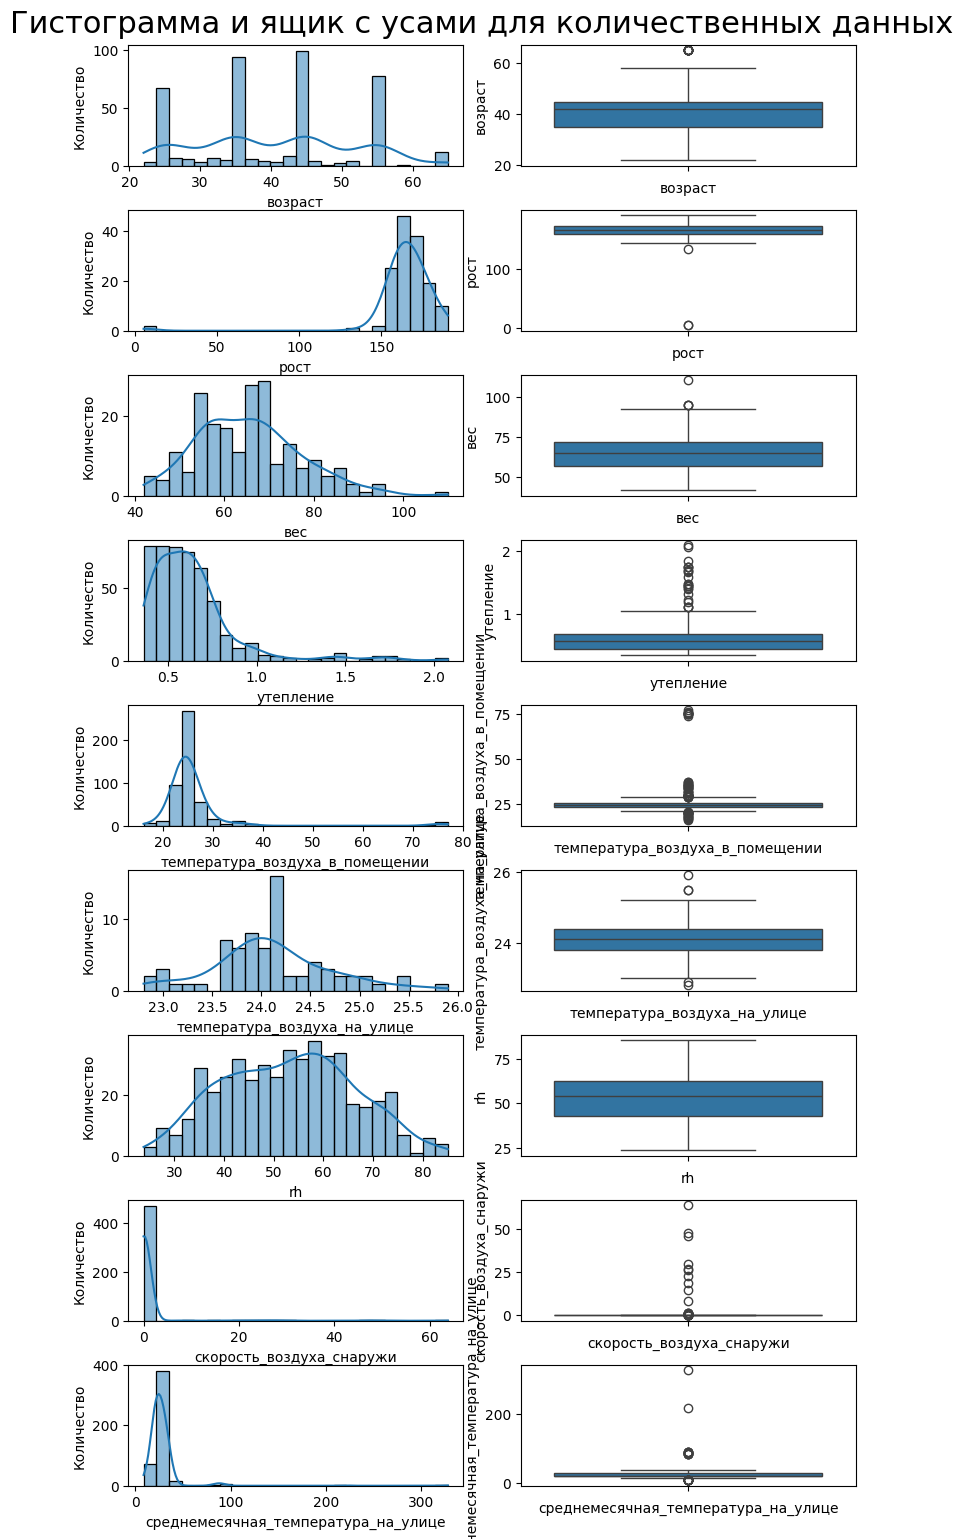

In [9]:
#гистограммы и ящики с усами для количественных переменных
col = ["возраст",
       "рост",
       "вес",
       'утепление',
       "температура_воздуха_в_помещении",
       "температура_воздуха_на_улице",
       "rh",
       "скорость_воздуха_снаружи",
       "среднемесячная_температура_на_улице"
]
plot_hist(df, col)

Столбцы "рост", "температура воздуха в помещении", "температура воздуха на улице", "скорость воздуха", "среднемесячная температура на улице" имеют выбросы

In [10]:
def diagramma(y, name=None):
  y_v = y.value_counts()
  plt.pie(y_v, autopct='%.2f%%')
  plt.legend(y_v.index, loc='lower left', bbox_to_anchor=(1.0, 0., 0.5, 0.5))
  if name is None:
    plt.title(y.name)
  else:
    plt.title(name)
  plt.show()

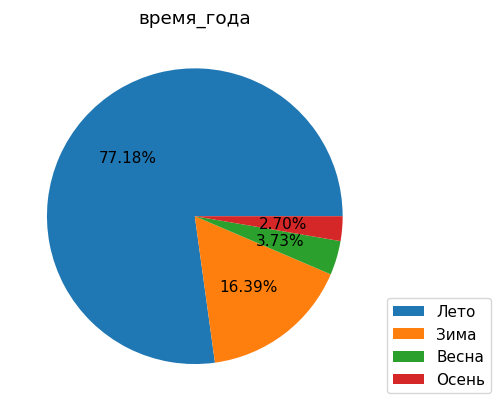

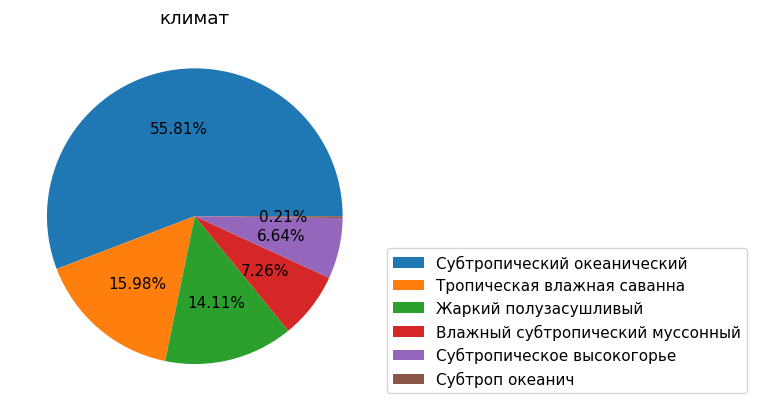

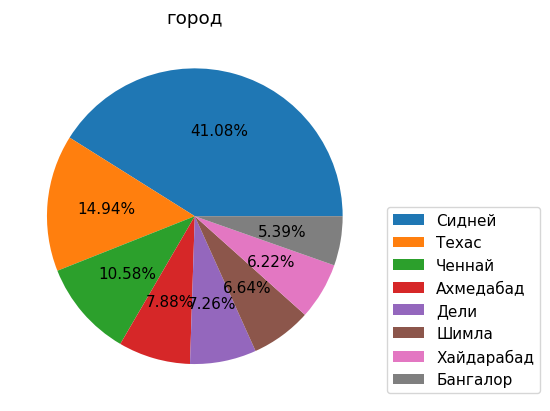

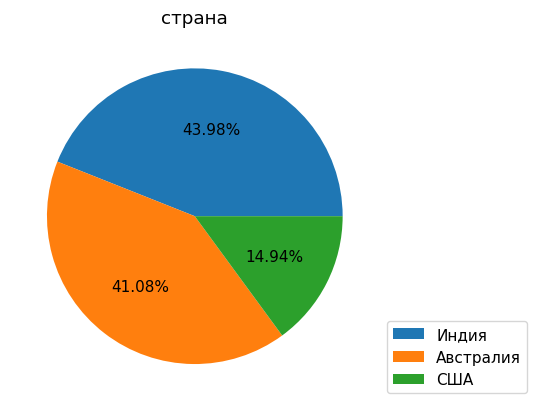

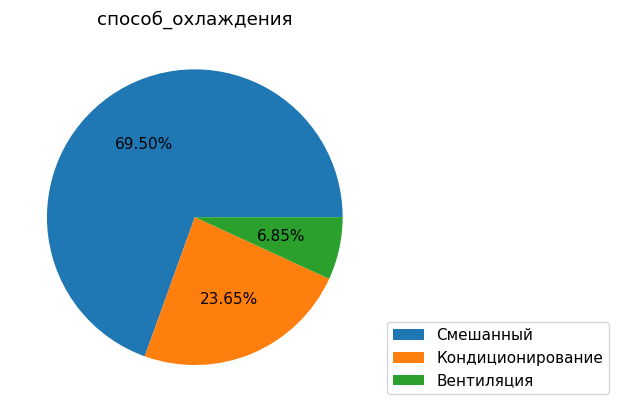

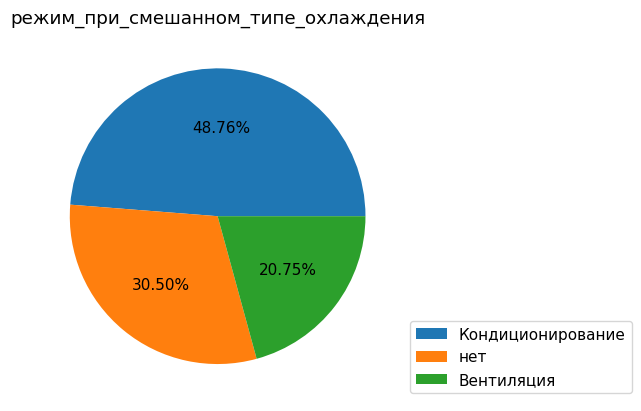

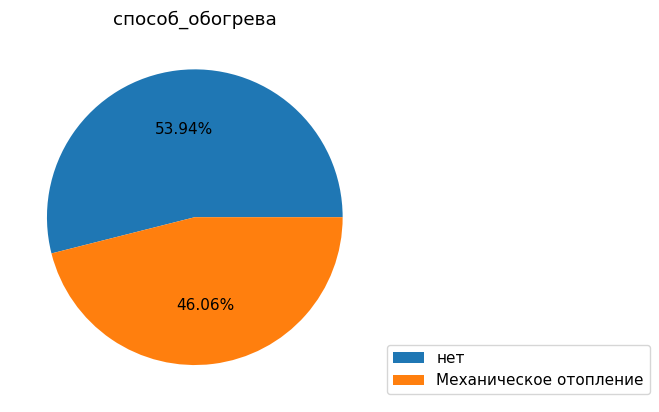

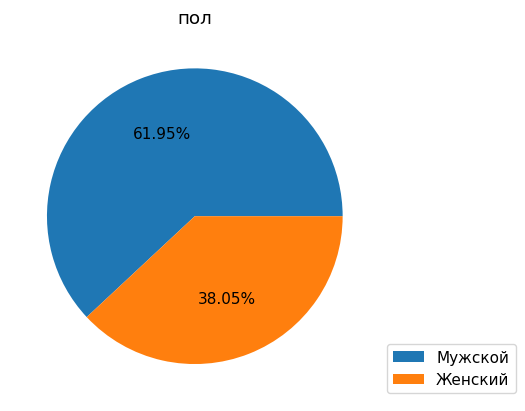

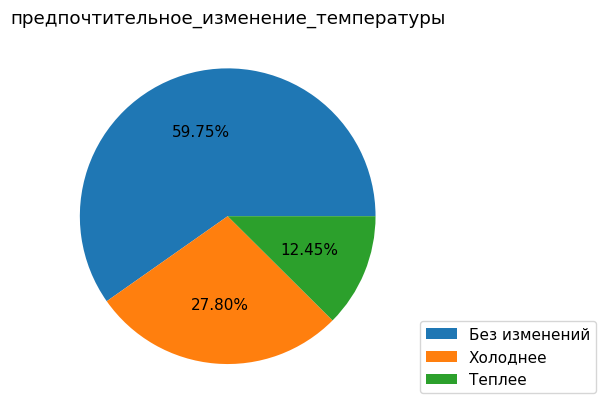

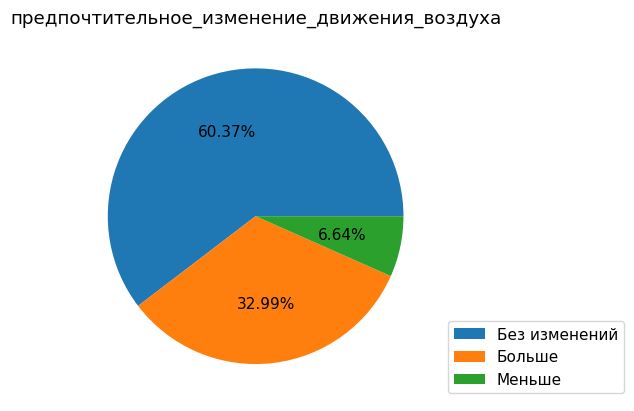

In [11]:
diagramma(df["время_года"])
diagramma(df["климат"])
diagramma(df["город"])
diagramma(df["страна"])
diagramma(df["способ_охлаждения"])
diagramma(df["режим_при_смешанном_типе_охлаждения"])
diagramma(df["способ_обогрева"])
diagramma(df["пол"])
diagramma(df["предпочтительное_изменение_температуры"])
diagramma(df["предпочтительное_изменение_движения_воздуха"])

In [12]:
df['рост'][df['рост'] < 100]

287    5.23
306    5.74
Name: рост, dtype: float64

Похоже, что рост просто записан в футах.

5.23 фут = 1.59 м

5.74 фут = 1.75 м

In [13]:
df['рост'].replace([5.23, 5.74], [159.4, 175], inplace=True)

In [14]:
df['температура_воздуха_в_помещении'][df['температура_воздуха_в_помещении'] > 40]

1     74.8
7     74.8
9     76.4
23    77.0
33    74.9
38    75.5
41    75.7
45    74.0
54    75.7
67    74.9
Name: температура_воздуха_в_помещении, dtype: float64

Выбросы в шкале "температура_воздуха_в_помещении", возможно, записаны в Фаренгейтах. В таком случае значения около 70 в Фаренгейтах при переходе в Цельсии - становятся не больше 25.

In [15]:
df['температура_воздуха_в_помещении'] = df['температура_воздуха_в_помещении'].apply(lambda x: (x - 32) / 1.8 if x > 40 else x)

In [16]:
df[['скорость_воздуха_снаружи', 'страна']][df['скорость_воздуха_снаружи'] > 20]

,скорость_воздуха_снаружи,страна
3,27.16,США
4,63.83,США
26,46.00,США
28,47.97,США
31,29.61,США
53,26.49,США
59,22.68,США


Заметим, что в США скорость измеряется в милях в час. Поэтому попробуем перевести в метры в секунду.

In [17]:
df[['скорость_воздуха_снаружи', 'страна']][df['скорость_воздуха_снаружи'] > 20].applymap(lambda x: x / 2.236936 if isinstance(x, float) else x)

,скорость_воздуха_снаружи,страна
3,12.141608,США
4,28.534567,США
26,20.563843,США
28,21.444512,США
31,13.236856,США
53,11.842091,США
59,10.138869,США


Видим, что даже так есть значения под 20 м/с. По шкале Бофорта это шторм. Поэтому мы оставим эти значения как важные случаи.

In [18]:
df['скорость_воздуха_снаружи'] = df['скорость_воздуха_снаружи'].apply(lambda x: x / 2.236936 if x > 20 else x)

In [19]:
df['среднемесячная_температура_на_улице'][df['среднемесячная_температура_на_улице'] >= 40]

1      84.0
11    328.0
14     84.0
20     91.0
28     91.0
30     91.0
34     89.0
39     89.0
44     84.0
67     84.0
68     91.0
81    220.0
Name: среднемесячная_температура_на_улице, dtype: float64

Значения не выше ста поддаются логике, что это Фаренгейты. 220 и 328 - скорее всего ошибки в записи, должно быть 22.0 и 38.0.

In [20]:
df['среднемесячная_температура_на_улице'].replace([220.0, 328.0], [22.0, 32.8], inplace=True)
df['среднемесячная_температура_на_улице'] = df['среднемесячная_температура_на_улице'].apply(lambda x: (x - 32) / 1.8 if x > 40 else x)

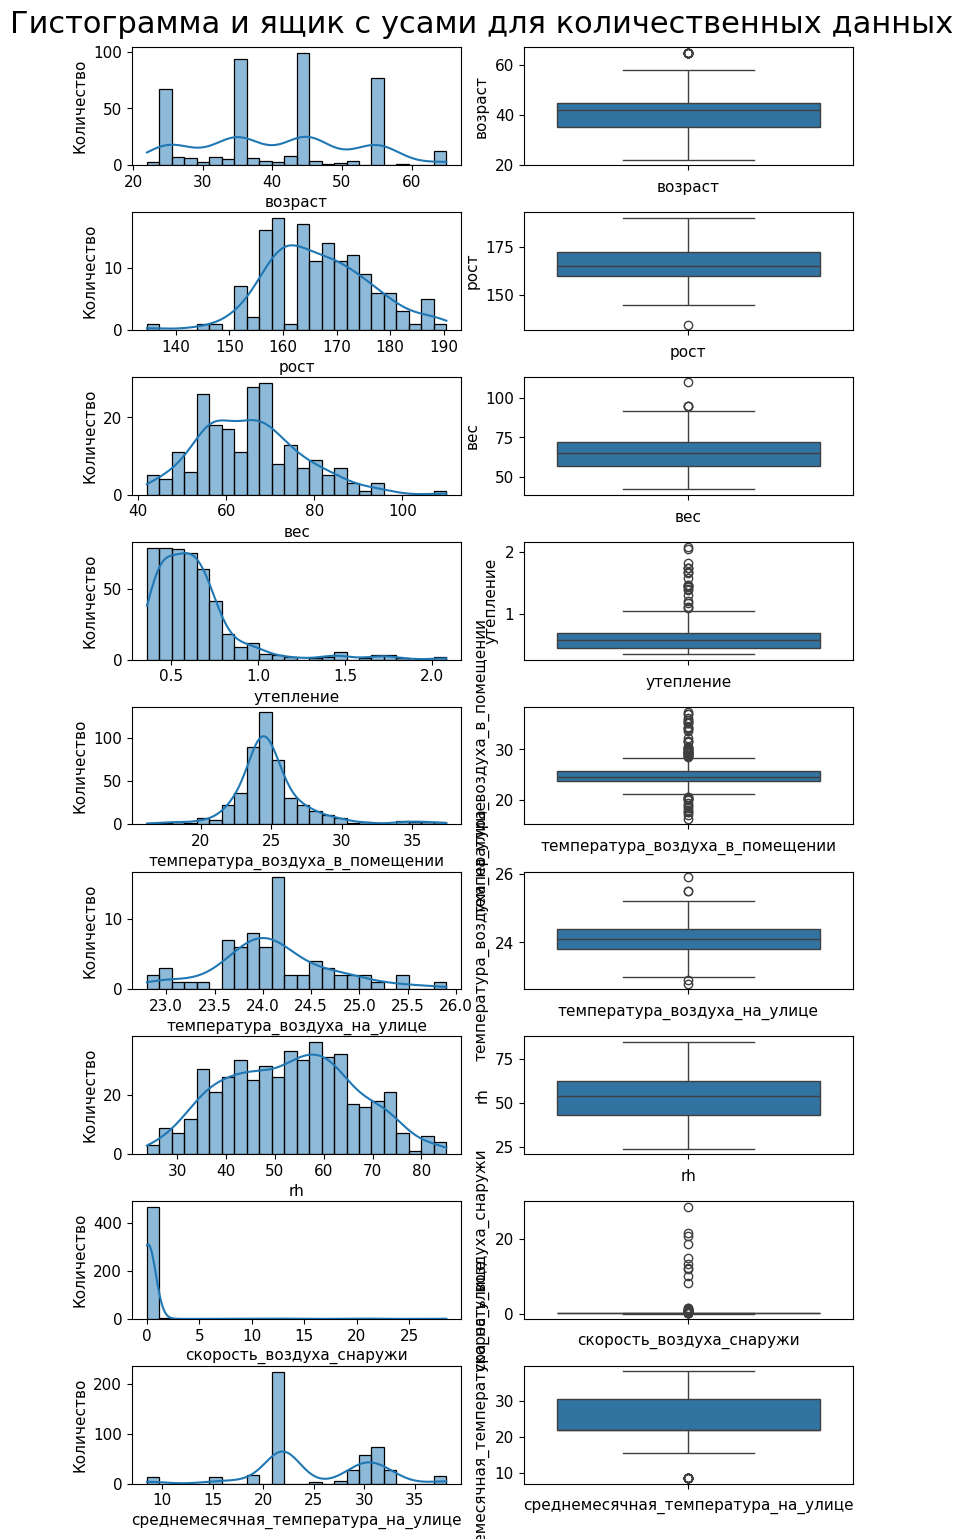

In [21]:
plot_hist(df, col)

Посмотрим на соотношение пропусков в колонках, где они есть

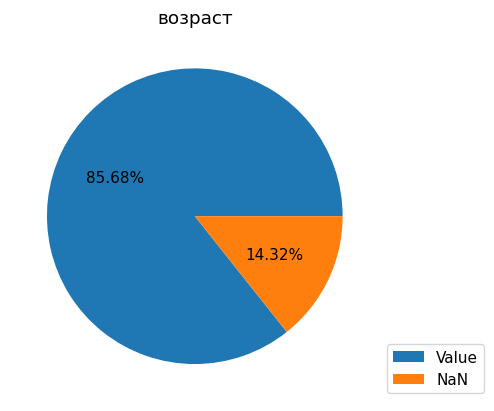

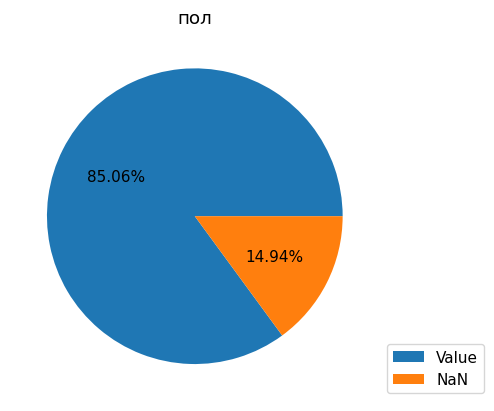

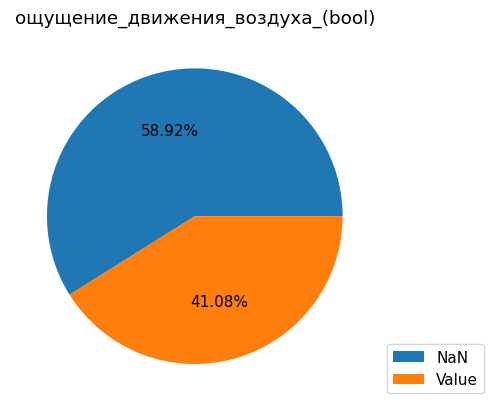

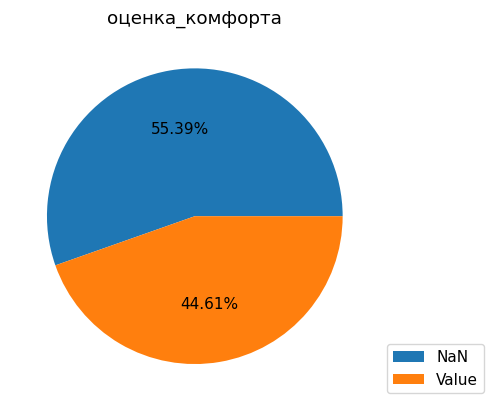

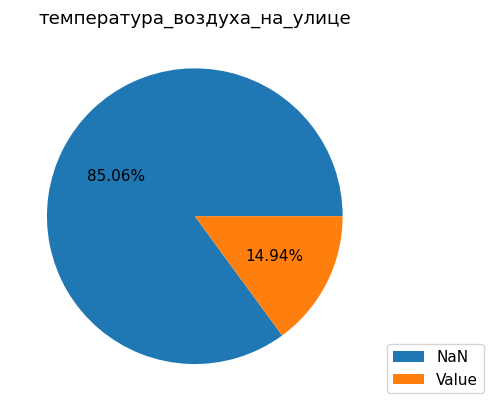

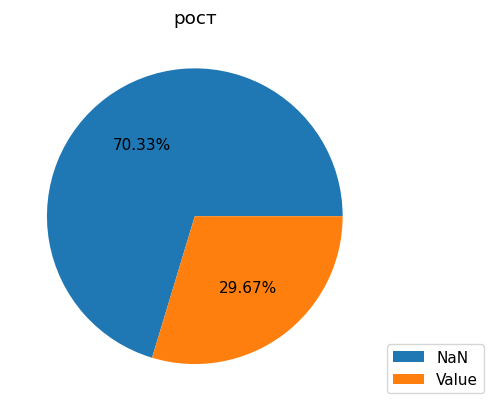

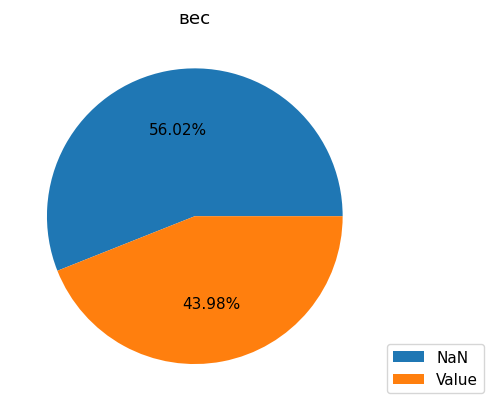

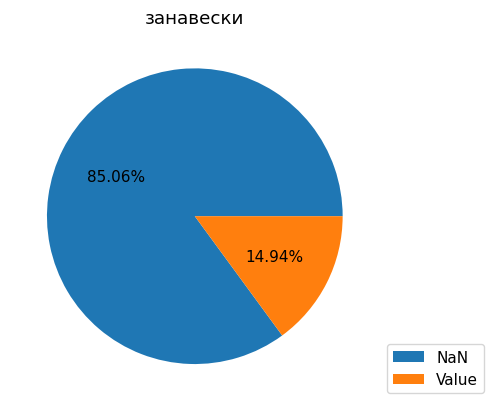

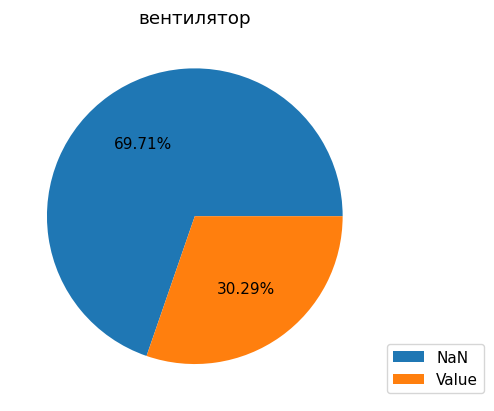

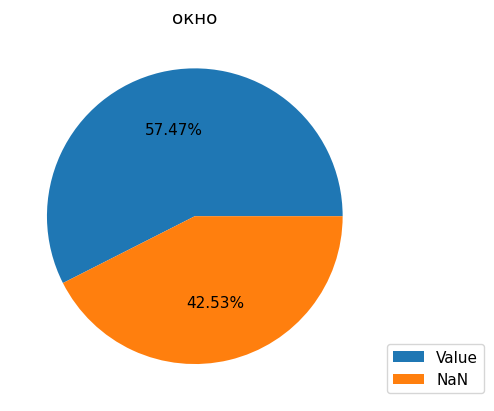

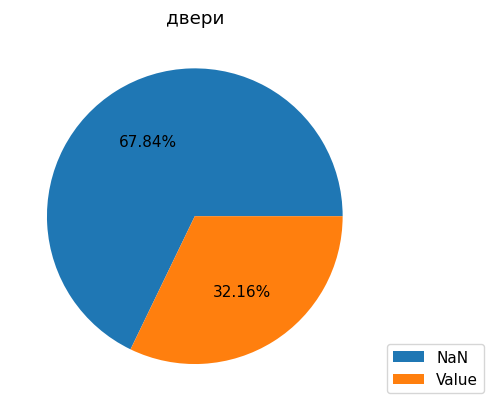

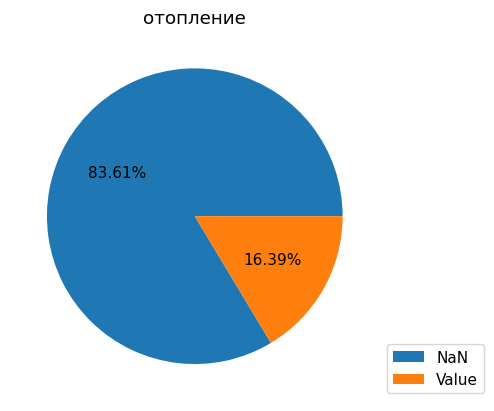

In [22]:
for col in df.columns:
    if df[col].isna().sum() != 0:
        diagramma(df[col].isna().apply(lambda x: 'NaN' if x else 'Value'))

#### Заполняем возраст медианой по городам

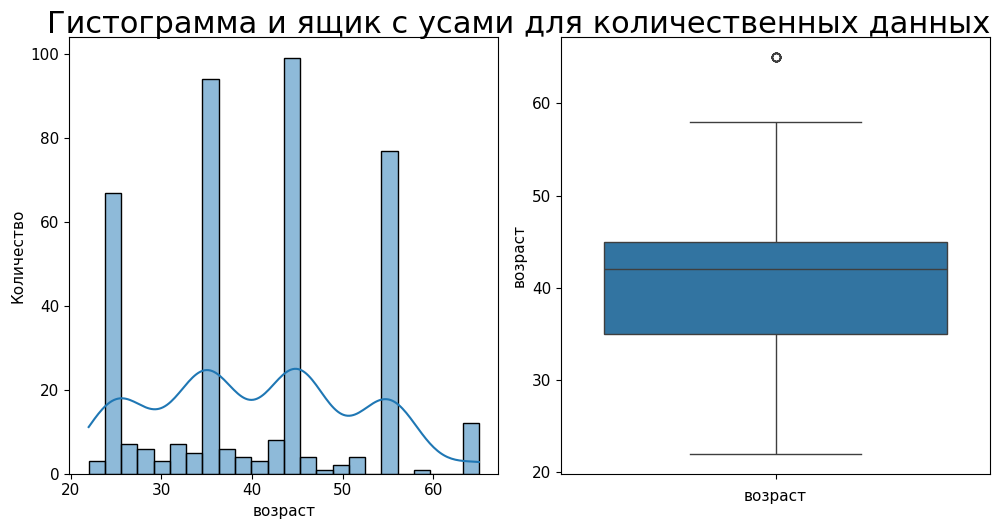

In [23]:
plot_hist(df, ['возраст'])

In [24]:
df1 = df[df['город']!='Хайдарабад']
gb = df1.groupby(['город', 'пол'])['возраст']
gb.head()

72     55.0
73     55.0
74     55.0
75     25.0
76     35.0
77     45.0
78     35.0
79     35.0
80     55.0
81     55.0
270    45.0
272    35.0
273    35.0
274     NaN
275    55.0
277    35.0
278    45.0
279    45.0
281    25.0
282     NaN
284    55.0
285    55.0
286    55.0
287    35.0
288     NaN
289    55.0
290    35.0
291     NaN
292    25.0
293    55.0
295    25.0
296    25.0
297    35.0
298    55.0
299    45.0
300    25.0
301    55.0
302    45.0
303    35.0
306    45.0
307    35.0
309    25.0
311    55.0
314    25.0
315    35.0
316     NaN
317     NaN
320     NaN
323    25.0
325    25.0
332    45.0
333    25.0
336    25.0
340    25.0
341    35.0
342    55.0
345    55.0
346    45.0
349    45.0
356    35.0
Name: возраст, dtype: float64

In [26]:
md = gb.median()
for city, sex in md.index:
    cond = (df['город'] == city) & (df['пол'] == sex)
    if not md.isna()[city]:
        df['возраст'][cond] = df['возраст'][cond].fillna(md[city])
    else:
        df['возраст'][cond] = df['возраст'][cond].fillna(df['возраст'][(df['страна'] == df[df['город'] == city]['страна'].unique()[0]) & (df['пол'] == sex)].median())

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

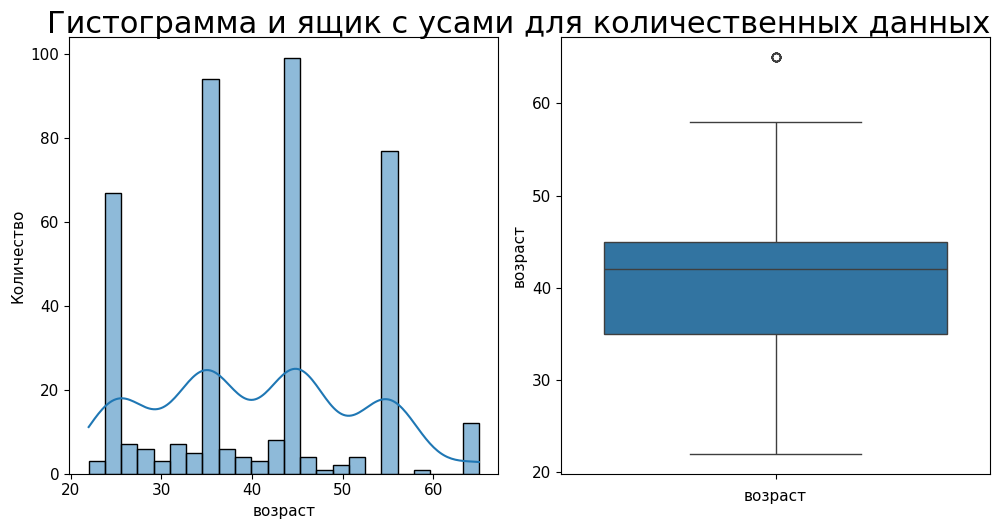

In [27]:
plot_hist(df, ['возраст'])

#### Заполняем пол, сохраняя отношение М/Ж в группах по городам

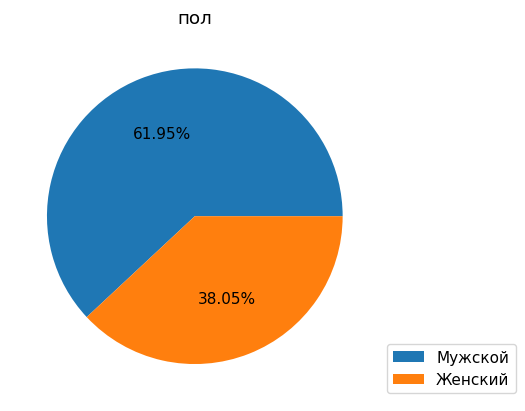

In [28]:
diagramma(df['пол'])

In [29]:
gb = df.groupby('город')['пол']
glbrel = df['пол'].value_counts()['Мужской'] / df['пол'].value_counts()['Женский']
for key, it in gb:
    vc = it.value_counts()
    if vc.size and vc['Мужской'] and vc['Женский']:
        rel = vc['Мужской'] / vc['Женский']
    else:
        rel = glbrel
    ln = len(it)
    f = int(round(ln / (rel + 1)))
    m = ln - f
    df['пол'].fillna({it.index[i]: ('Мужской' if i < m else 'Женский') for i in range(ln)}, inplace=True)

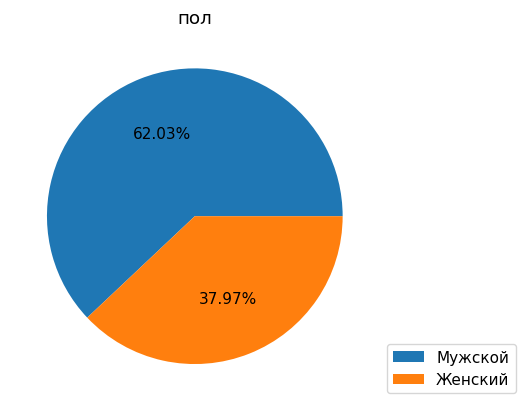

In [30]:
diagramma(df['пол'])

#### Заполняем рост медианой в группах по возрасту

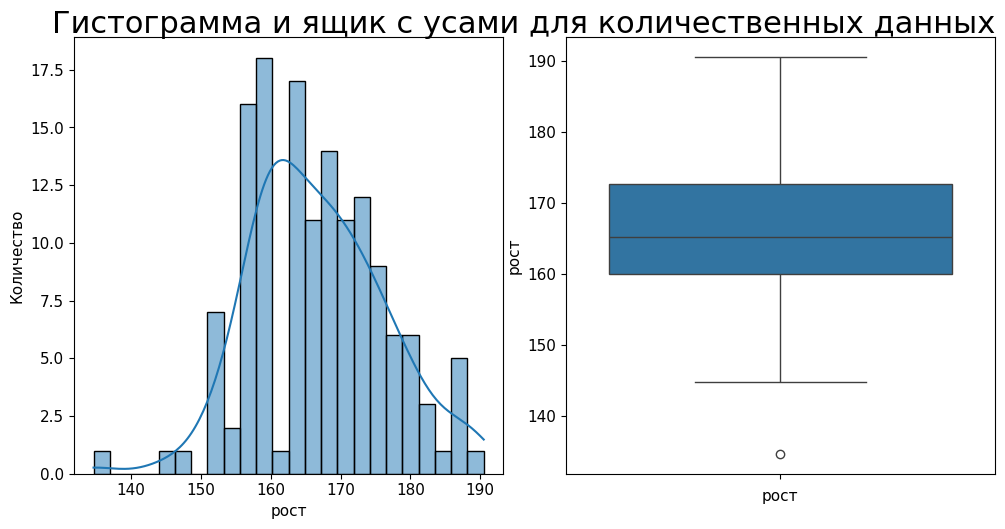

In [31]:
plot_hist(df,['рост'])

In [32]:
df['возраст'] = pd.array(df['возраст'], dtype=pd.Int64Dtype())
df.loc[df['рост'] <= df['рост'].quantile(0.01), 'рост'] = np.nan
gb1 = df.groupby(['возраст','пол'])['рост']
for key, item in gb1:
    key_mean = gb1.get_group(key).median()
    df["рост"] = df["рост"].fillna(key_mean)

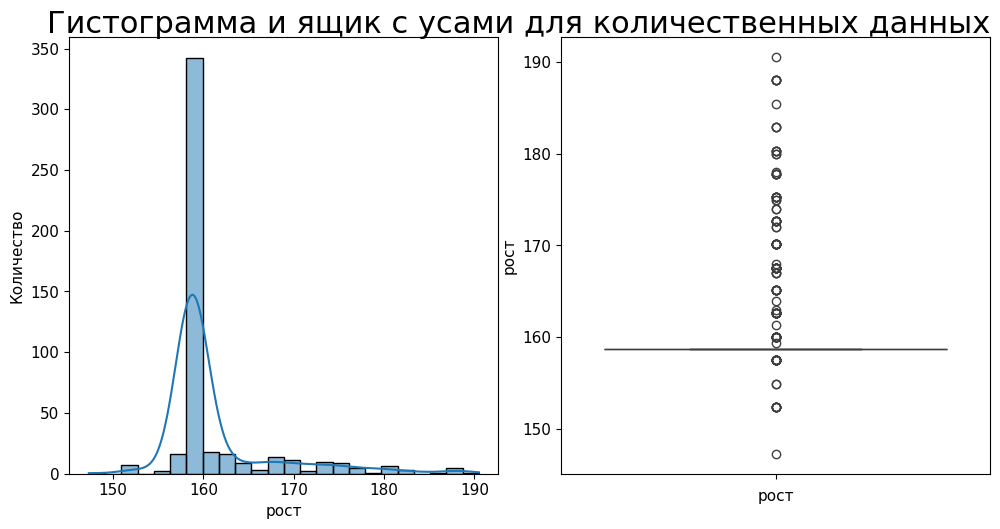

In [33]:
plot_hist(df,['рост'])

#### Заполняем вес медианой по возрастным группам

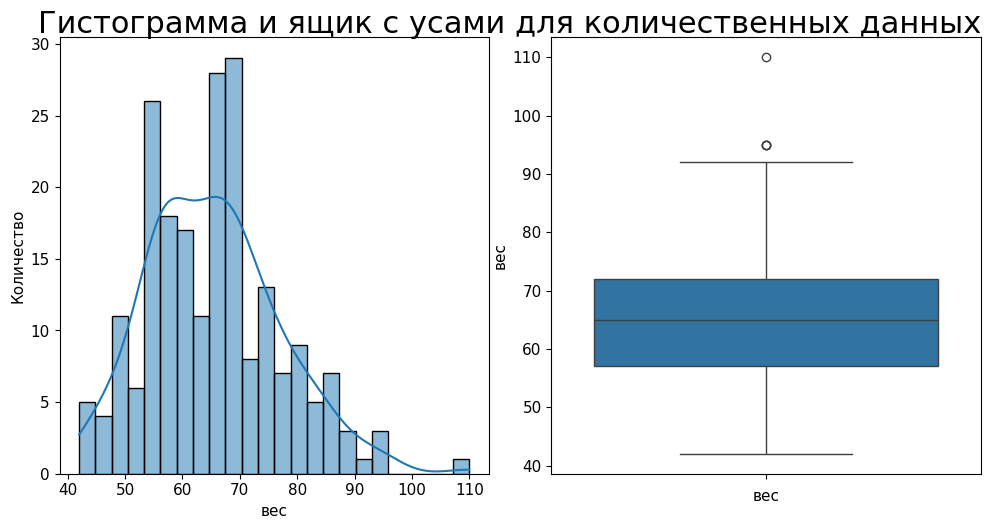

In [34]:
plot_hist(df,['вес'])

In [35]:
gb2 = df.groupby(['возраст','пол'])['вес']
for key, item in gb2:
    key_mean = gb2.get_group(key).median()
    df["вес"] = df["вес"].fillna(key_mean)

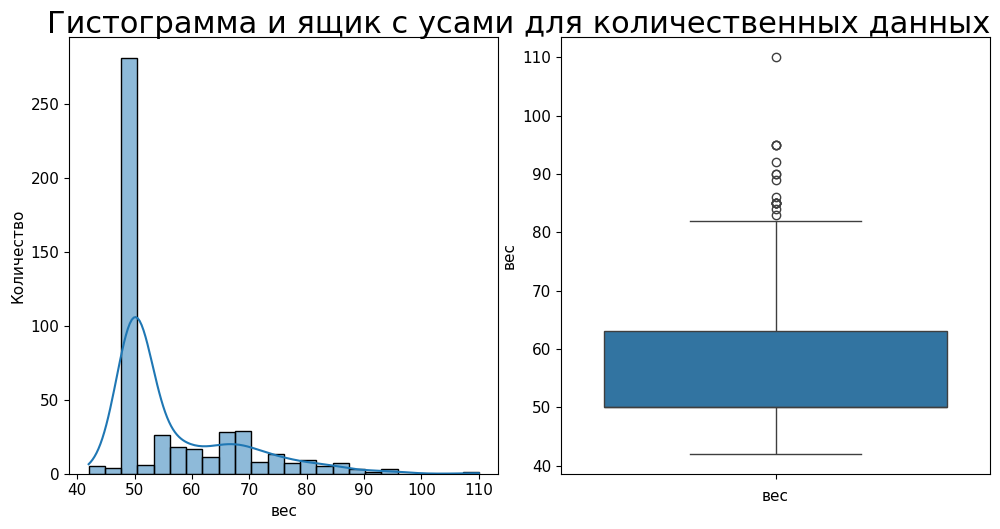

In [36]:
plot_hist(df,['вес'])

#### Заполняем занавески, сохраняя отношение есть/нет

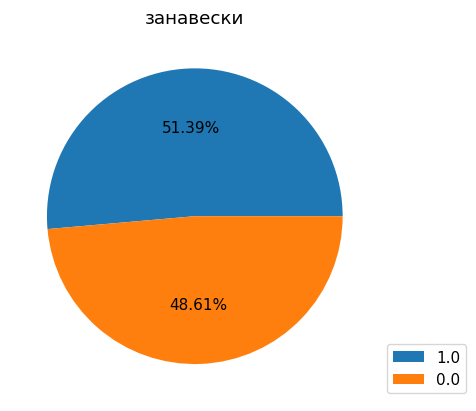

In [37]:
diagramma(df['занавески'])

In [46]:
vc = df['занавески'].value_counts()
rel = vc[1] / vc[0]
z = int(round(len(df) / (rel + 1)))
o = ln - z
df['занавески'].fillna({i: (1 if i < o else 0) for i in df.index}, inplace=True)

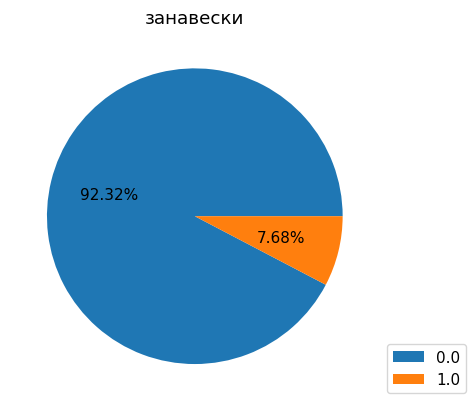

In [39]:
diagramma(df['занавески'])

#### Заполняем окно и двери, сохраняя отношение есть/нет

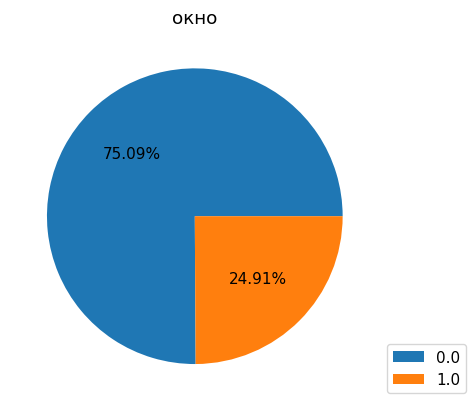

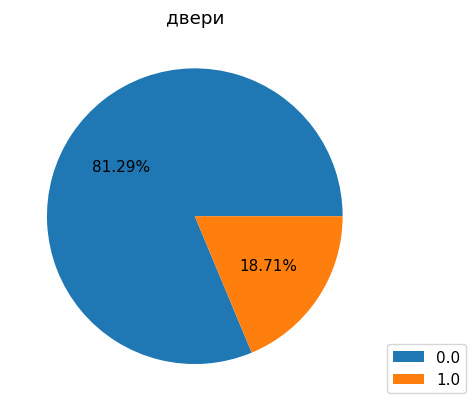

In [40]:
diagramma(df['окно'])
diagramma(df['двери'])

In [41]:
df['вентилятор'] = pd.array(df['вентилятор'], dtype=pd.Int64Dtype())
df['окно'] = pd.array(df['окно'], dtype=pd.Int64Dtype())
df['двери'] = pd.array(df['двери'], dtype=pd.Int64Dtype())
def zapolnenie(st2):
    gb = df.groupby(['климат','время_года'])[st2.name]
    dolya = 0
    for group_name, df_group in gb:
        if df_group.isna().sum() == 0:
            dolya_1 = df_group.value_counts()[1]/(len(df_group))
            break
    dolya_1 = dolya_1/len(df_group)
    for group_name, df_group in gb:
        if df_group.isna().sum() != 0:
            kolvo_1 = int(round(dolya_1 * len(df_group),0))
            df[st2.name] = df[st2.name].fillna({df_group.index[i]: (1 if i < kolvo_1 else 0) for i in range(len(df_group))})

zapolnenie(df['двери'])
zapolnenie(df['вентилятор'])
zapolnenie(df['окно'])

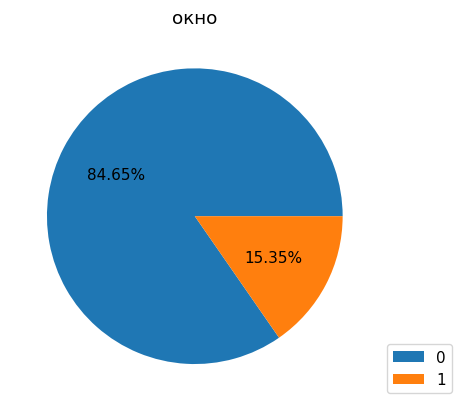

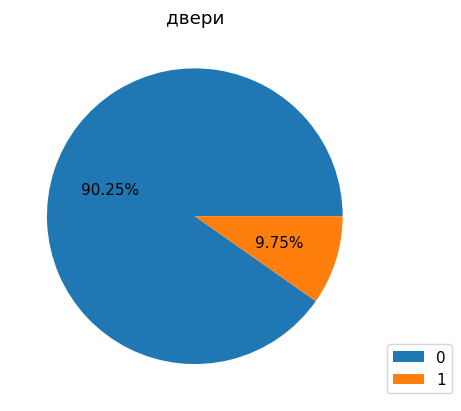

In [42]:
diagramma(df['окно'])
diagramma(df['двери'])

#### Удаляем столбец отопление, т.к. там слишком много пропусков

In [43]:
df.drop('отопление', axis=1, inplace=True)

#### Изменение типов данных в столбцах

In [44]:
df['занавески'] = pd.array(df['занавески'], dtype=pd.Int64Dtype())
df['ощущение_температуры_(bool)'] = pd.array(df['ощущение_температуры_(bool)'], dtype=pd.Int64Dtype())
df['ощущение_движения_воздуха_(bool)'] = pd.array(df['ощущение_движения_воздуха_(bool)'], dtype=pd.Int64Dtype())

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 482 entries, 0 to 481
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   год                                          482 non-null    object 
 1   время_года                                   482 non-null    object 
 2   климат                                       482 non-null    object 
 3   город                                        482 non-null    object 
 4   страна                                       482 non-null    object 
 5   способ_охлаждения                            482 non-null    object 
 6   режим_при_смешанном_типе_охлаждения          482 non-null    object 
 7   способ_обогрева                              482 non-null    object 
 8   возраст                                      413 non-null    Int64  
 9   пол                                          482 non-null    object 
 10  ощущени

#### Визуализация количества пропусков после обработки

<Axes: >

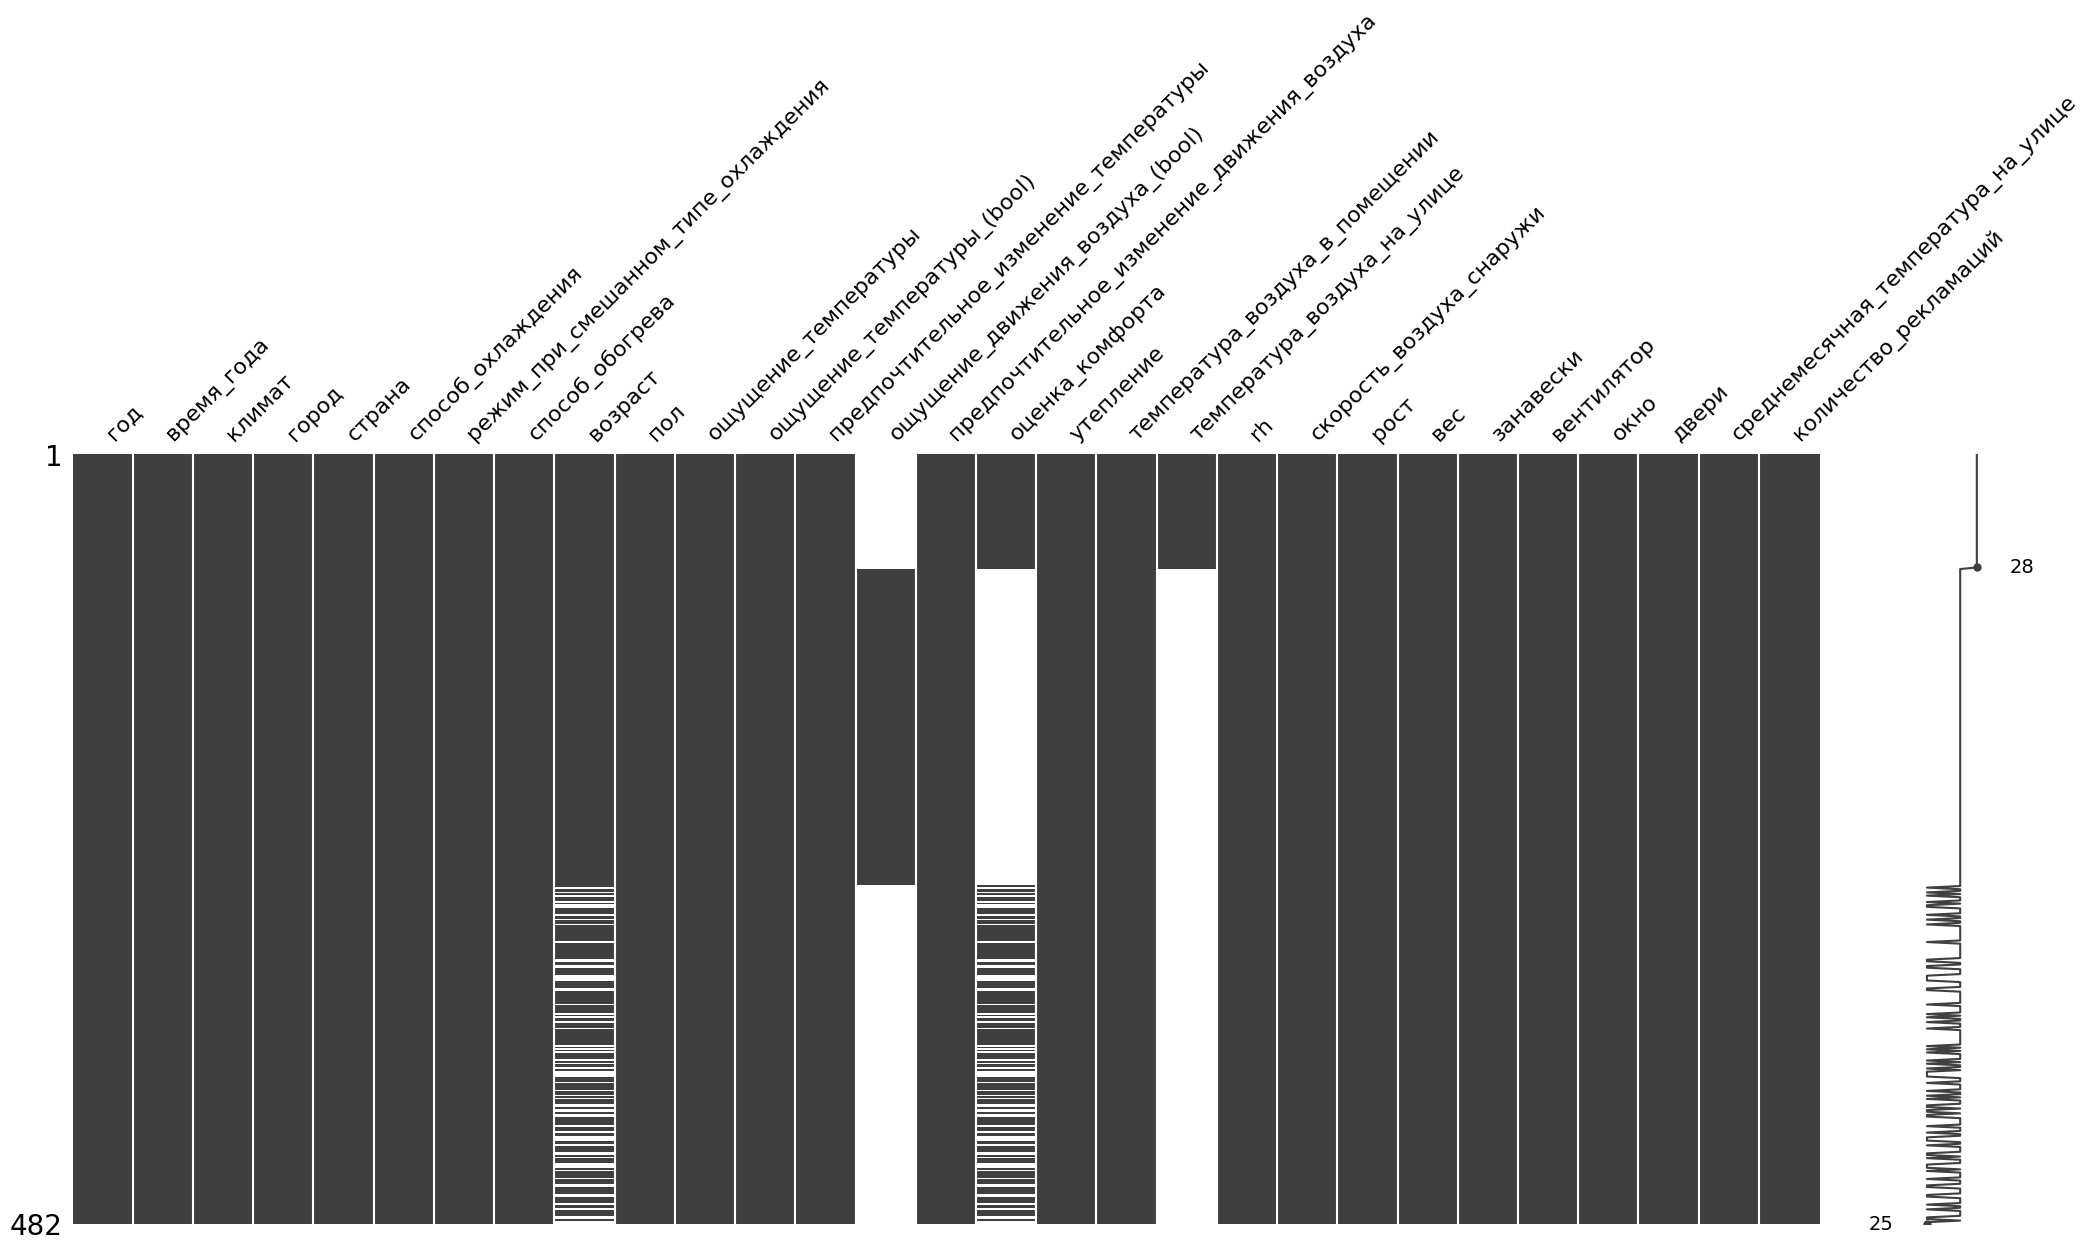

In [45]:
msno.matrix(df)

In [ ]:
df.to_csv('raw_data.csv')

### Работа с корреляциями

In [ ]:
df['год'] = df['год'].astype(str)
df['countmen'] = 1
# Столбец countmen для будущего подсчета людей в каждой группе
df.head()

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,скорость_воздуха,рост,вес,занавески,вентилятор,окно,двери,среднемесячная_температура_на_улице,количество_рекламаций,countmen
0,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,22,Мужской,...,0.26,170.2,63.0,1.0,1.0,0.0,0.0,28.9,0,1
2,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,42,Мужской,...,0.08,170.2,63.0,0.0,0.0,0.0,0.0,32.8,0,1
5,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,27,Мужской,...,0.21,170.2,63.0,1.0,1.0,0.0,0.0,28.9,0,1
6,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,32,Мужской,...,0.10,170.2,63.0,1.0,1.0,0.0,0.0,32.8,0,1
8,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,43,Мужской,...,0.15,170.2,63.0,1.0,1.0,0.0,0.0,32.8,0,1


In [ ]:
# Шкалы всех столбцов для последующей корреляции
types = {
    # 'год': 'cat',
    'город': 'cat',
    # 'страна': 'cat',
    'возраст': 'num',
    # 'пол': 'cat',
    'утепление':'num',
    'количество_рекламаций': 'num',
    'время_года': 'cat',
    'климат': 'cat',
    'способ_охлаждения': 'cat',
    # 'режим_при_смешанном_типе_охлаждения': 'cat',
    'способ_обогрева': 'cat',
    # 'температура_воздуха_в_помещении': 'num',
    'rh': 'num',
    'скорость_воздуха': 'num',
    # 'занавески': 'cat',
    'вентилятор': 'num',
    # 'окно': 'cat',
    # 'двери': 'cat',
    'среднемесячная_температура_на_улице': 'num'}
subs = {'ощущение_температуры': 'cat',
    'ощущение_температуры_(bool)': 'cat',
    'предпочтительное_изменение_температуры': 'cat',
    # 'ощущение_движения_воздуха_(bool)': 'cat',
    'предпочтительное_изменение_движения_воздуха': 'cat',
    'оценка_комфорта': 'cat'}

# Создание функций для добавления категориальных столбцов датафрейма
def changerecl(x):
    if x <= 1:
        return 'мало'
    if x == 2:
        return 'средне'
    if x > 2:
        return 'много'

def changeage(x):
    if x <= 44:
        return 'молодой возраст'
    if 45 <= x <= 59:
        return 'средний возраст'
    if x >= 60:
        return 'пожилой возраст'

def standr_comf_rh(df):
    '''Источник:
            https://oborona.media/microclimate-at-work/'''
    if 40 <= df['rh'] <= 60:
        return 'OK'
    else:
        return 'not OK'
# Функции для выполнения корреляций

#реализация хи-квадрат
def hi2(g1, g2):
    ct = pd.crosstab(g1, g2)
    chi2 = chi2_contingency(ct)
    return (chi2.statistic / (df.shape[0] * (min(df.shape) - 1))) ** 0.5, chi2.pvalue

# функция, которая вычисляет корреляцию и p-уровень между двумя факторами, на основе их типа
def correlation(g1, g2, type1, type2):
    res = 0
    # разные шкалы
    if type1 != type2:
        norm = 0
        if type1 == 'cat':
            norm = shapiro(g2).pvalue >= 0.05 # проверка на нормальность
            gs = [g2[g1 == i] for i in g1.unique()] # разбиение по группам для случаев, когда у категориального фактора больше 2 уровней
            ln = len(g1.unique())
        else:
            gs = [g1[g2 == i] for i in g2.unique()] # разбиение по группам для случаев, когда у категориального фактора больше 2 уровней
            norm = shapiro(g1).pvalue >= 0.05 # проверка на нормальность
            ln = len(g2.unique())
        if not norm:
            if ln == 2:
                res = mannwhitneyu(*gs)
                method = 0
            else:
                res = kruskal(*gs)
                method = 1
        else:
            if ln == 2:
                res = ttest_ind(*gs)
                method = 2
            else:
                res = f_oneway(*gs)
                method = 3
    else: #одинаковые шкалы
        if type1 == 'cat':
            method = 4
            res = hi2(g1, g2)
        else:
            norm = shapiro(g1).pvalue >= 0.05 and shapiro(g2).pvalue >= 0.05 # проверка на нормальность
            if not norm:
                res = spearmanr(g1, g2)
                method = 5
            else:
                res = pearsonr(g1, g2)
                method = 6
    return res[0], res[1], method

In [ ]:
# Категоризация требуемых данных в отдельных столбцах
df['реклам_категория'] = df['количество_рекламаций'].map(changerecl)
df['возрастная_категория'] = df['возраст'].map(changeage)
df.head()

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,вес,занавески,вентилятор,окно,двери,среднемесячная_температура_на_улице,количество_рекламаций,countmen,реклам_категория,возрастная_категория
0,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,22,Мужской,...,63.0,1.0,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст
2,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,42,Мужской,...,63.0,0.0,0.0,0.0,0.0,32.8,0,1,мало,молодой возраст
5,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,27,Мужской,...,63.0,1.0,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст
6,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,32,Мужской,...,63.0,1.0,1.0,0.0,0.0,32.8,0,1,мало,молодой возраст
8,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,43,Мужской,...,63.0,1.0,1.0,0.0,0.0,32.8,0,1,мало,молодой возраст


In [ ]:
dfmeanage = df[['пол', 'страна', 'возраст']].groupby(['пол', 'страна']).mean().round().astype(int)
dfmeanage.head()
# Рассчитать средний возраст респондентов по полу и стране

возраст
пол     страна            
Женский Австралия       46
        Индия           35
        США             38
Мужской Австралия       43
        Индия           37

In [ ]:
goodtemp = df.loc[df['предпочтительное_изменение_температуры'] == 'Без изменений']
goodtemp.head()
# Сбор всех данных с комфортной температурой

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,вес,занавески,вентилятор,окно,двери,среднемесячная_температура_на_улице,количество_рекламаций,countmen,реклам_категория,возрастная_категория
0,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,22,Мужской,...,63.0,1.0,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст
2,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,42,Мужской,...,63.0,0.0,0.0,0.0,0.0,32.8,0,1,мало,молодой возраст
5,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,27,Мужской,...,63.0,1.0,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст
8,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,43,Мужской,...,63.0,1.0,1.0,0.0,0.0,32.8,0,1,мало,молодой возраст
12,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,32,Мужской,...,63.0,0.0,0.0,0.0,0.0,32.8,0,1,мало,молодой возраст


In [ ]:
dfcomftemp = goodtemp[['температура_воздуха_в_помещении', 'возрастная_категория']].groupby('возрастная_категория').mean().round(1)
dfcomftemp.head()
# Рассчитать среднюю комфортную температуру в зависимости от возрастной категории

,температура_воздуха_в_помещении
возрастная_категория,
молодой возраст,24.7
пожилой возраст,25.4
средний возраст,24.5


In [ ]:
df3 =  goodtemp[['страна', 'пол', 'countmen']].groupby(['страна', 'пол']).count()
df3.reset_index(inplace=True)
for i in range(len(df3)):
    df3['countmen'][i] = round(df3['countmen'][i] / len(df.loc[(df['страна'] == df3['страна'][i]) & (df['пол'] == df3['пол'][i])]) * 100)

df = df.merge(df3, left_on=['пол', 'страна'], right_on=['пол', 'страна'])
df = df.rename(columns = {'countmen_x': 'countmen', 'countmen_y': 'precent_satisf'})
df.head()

# Добавить столбец с процентом удовлетворенных респондентов температурой воздуха в помещении относительно всех респондентов одной страны и одного пола

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,занавески,вентилятор,окно,двери,среднемесячная_температура_на_улице,количество_рекламаций,countmen,реклам_категория,возрастная_категория,precent_satisf
0,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,22,Мужской,...,1.0,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст,56
1,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,42,Мужской,...,0.0,0.0,0.0,0.0,32.8,0,1,мало,молодой возраст,56
2,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,27,Мужской,...,1.0,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст,56
3,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,32,Мужской,...,1.0,1.0,0.0,0.0,32.8,0,1,мало,молодой возраст,56
4,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,43,Мужской,...,1.0,1.0,0.0,0.0,32.8,0,1,мало,молодой возраст,56


In [ ]:
dftypeohl = df[['способ_охлаждения', 'температура_воздуха_в_помещении', 'rh']].groupby('способ_охлаждения').median()
dftypeohl.head()
# Рассчитать медианное значение температуры и влажности для каждого типа охлаждения

,температура_воздуха_в_помещении,rh
способ_охлаждения,,
Вентиляция,25.30,46.3
Кондиционирование,24.35,43.7
Смешанный,24.65,56.4


In [ ]:
pivot = pd.pivot_table(df, index=['страна', 'пол', 'возрастная_категория'], values=['температура_воздуха_в_помещении', 'температура_воздуха_на_улице', 'rh'],
                       aggfunc='mean').round(2)

'''
Составить сводную таблицу, в которой данные будут сгруппированы по стране, полу, возрастной группе
и подсчитаны средняя температура воздуха в помещении, на улице и средняя относительная влажность для каждой из этих групп.
'''
pivot.head()


rh  \
страна    пол     возрастная_категория          
Австралия Женский молодой возраст       61.37   
                  пожилой возраст       44.55   
                  средний возраст       61.37   
          Мужской молодой возраст       61.67   
                  пожилой возраст       64.37   

                                        температура_воздуха_в_помещении  \
страна    пол     возрастная_категория                                    
Австралия Женский молодой возраст                                 23.84   
                  пожилой возраст                                 24.90   
                  средний возраст                                 24.10   
          Мужской молодой возраст                                 24.15   
                  пожилой возраст                                 24.73   

                                        температура_воздуха_на_улице  
страна    пол     возрастная_категория                                
Австралия Женский молодой возраст                                NaN  
                  пожилой возраст                                NaN  
                  средний возраст                                NaN  
          Мужской молодой возраст                                NaN  
                  пожилой возраст                                NaN

In [ ]:
df['стандр_комф_вл'] = df.apply(standr_comf_rh, axis=1)
'''
Самостоятельно найти информацию по стандартной комфортной относительной влажности в помещениях (в нашем случае - офисы).
Создать новый категориальный столбец, в котором будет показано, удовлетворяет ли зафиксированная относительная влажность стандарту или нет.
Категории назначить самостоятельно.
'''
df.head()


,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,вентилятор,окно,двери,среднемесячная_температура_на_улице,количество_рекламаций,countmen,реклам_категория,возрастная_категория,precent_satisf,стандр_комф_вл
0,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,22,Мужской,...,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст,56,OK
1,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,42,Мужской,...,0.0,0.0,0.0,32.8,0,1,мало,молодой возраст,56,not OK
2,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,27,Мужской,...,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст,56,not OK
3,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,32,Мужской,...,1.0,0.0,0.0,32.8,0,1,мало,молодой возраст,56,OK
4,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,43,Мужской,...,1.0,0.0,0.0,32.8,0,1,мало,молодой возраст,56,not OK


<Axes: >

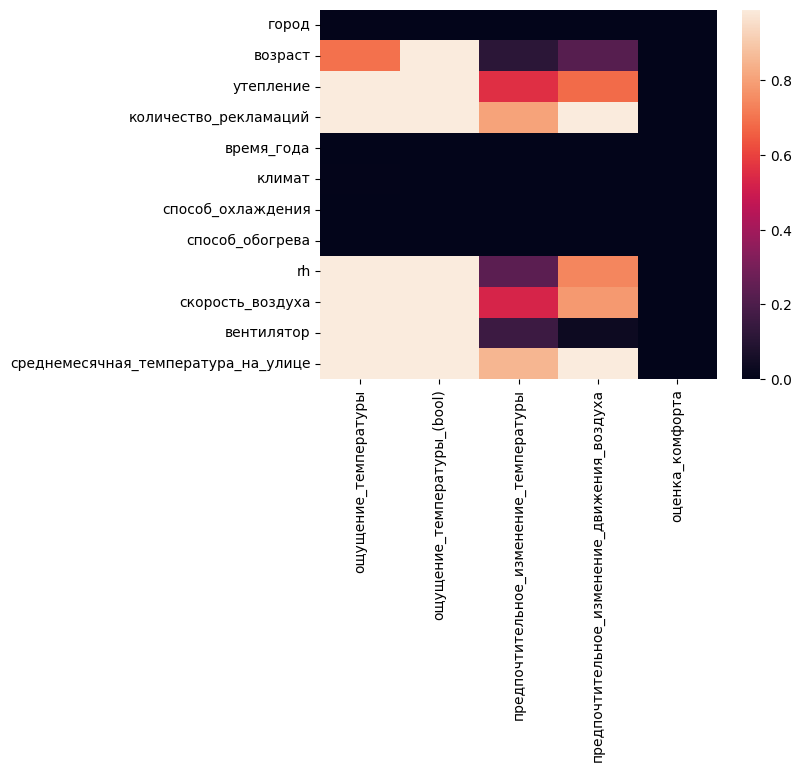

In [ ]:
# составляем хитмап корреляций
cols = list(types)
colssubs = list(subs)
resflat = []
res = np.zeros((len(cols), len(colssubs)), dtype='float32')
meths = np.zeros_like(res, dtype='O')
for i in range(len(cols)):
    for j in range(len(colssubs)):
        f1, f2 = cols[i], colssubs[j]
        statistics, pvalue, meth = correlation(df[f1], df[f2], types[f1], subs[f2])
        res[i, j] = statistics
        meths[i, j] = meth
        if pvalue < 0.05 and statistics > 0.5:
            resflat.append([f1 + ' ' + f2, statistics, pvalue, meth])
for meth in np.unique(meths):
    idx = meths == meth
    if meth <= 4:
        g = res[idx]
        for i in range(len(g)):
            if g[i] == np.nan:
                g[i] = 0
            elif g[i] >= 20:
                g[i] = 0.99
            else:
                g[i] = g[i] / 20
        res[idx] = g
dfress = pd.DataFrame(index=cols, columns=colssubs, data=res)
sns.heatmap(dfress.fillna(0))

### Проверка гипотез

In [ ]:
df.head()

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,вентилятор,окно,двери,среднемесячная_температура_на_улице,количество_рекламаций,countmen,реклам_категория,возрастная_категория,precent_satisf,стандр_комф_вл
0,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,22,Мужской,...,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст,56,OK
1,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,42,Мужской,...,0.0,0.0,0.0,32.8,0,1,мало,молодой возраст,56,not OK
2,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,27,Мужской,...,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст,56,not OK
3,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,32,Мужской,...,1.0,0.0,0.0,32.8,0,1,мало,молодой возраст,56,OK
4,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,43,Мужской,...,1.0,0.0,0.0,32.8,0,1,мало,молодой возраст,56,not OK


In [ ]:
correlation(df['способ_охлаждения'], df['оценка_комфорта'], 'cat', 'cat')

(0.0403780389385634, 0.3225687848299499, 4)

Способ охлаждения не вляет на оценку комфорта. Значение корреляции маленькое, следовательно, зависимость очень слабая. Уровень доверия больше 0.05, значит, ответу нельзя доверять.

In [ ]:
correlation(df['пол'], df['оценка_комфорта'], 'cat', 'cat')

(0.02309194819726559, 0.7127152082008428, 4)

Здесь уровень корреляции также маленький, однако p-уровень больше 0.05, поэтому по имеющимся данным выводов мы делать не можем

In [ ]:
df['возрастная_категория'] = df['возраст'].map(changeage)
correlation(df['возрастная_категория'], df['оценка_комфорта'], 'cat', 'cat')

(0.042029871066315255, 0.2298590866347347, 4)

Здесь уровень корреляции также маленький, однако p-уровень больше 0.05, поэтому по имеющимся данным выводов мы делать не можем

In [ ]:
correlation(df['количество_рекламаций'], df['оценка_комфорта'], 'num', 'cat')

(nan, nan, 1)

Здесь, к сожалению, не удалось подсчитать корреляцию, так как слишком много пропусков

In [ ]:
correlation(df['страна'], df['оценка_комфорта'], 'cat', 'num')

(nan, nan, 1)

Здесь, к сожалению, не удалось подсчитать корреляцию, так как слишком много пропусков

### Построение регрессионной модели

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df.head()

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,вентилятор,окно,двери,среднемесячная_температура_на_улице,количество_рекламаций,countmen,реклам_категория,возрастная_категория,precent_satisf,стандр_комф_вл
0,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,22,Мужской,...,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст,56,OK
1,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,42,Мужской,...,0.0,0.0,0.0,32.8,0,1,мало,молодой возраст,56,not OK
2,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,27,Мужской,...,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст,56,not OK
3,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,32,Мужской,...,1.0,0.0,0.0,32.8,0,1,мало,молодой возраст,56,OK
4,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,43,Мужской,...,1.0,0.0,0.0,32.8,0,1,мало,молодой возраст,56,not OK


In [ ]:
# здесь слишком много пропусков
df.drop('температура_воздуха_на_улице', axis=1, inplace=True)

In [ ]:
# столбцы, которые могут влиять на температуру воздуха в помещении
factors_list = ['время_года',
         'климат',
         'способ_охлаждения',
         'режим_при_смешанном_типе_охлаждения',
         'температура_воздуха_в_помещении',
         'способ_обогрева',
         'rh',
         'скорость_воздуха',
         'занавески',
         'вентилятор',
         'окно',
         'двери',
         'среднемесячная_температура_на_улице']
factors = df[factors_list]

In [ ]:
# шкалы этих столбцов
types = {
    'время_года': 'cat',
    'климат': 'cat',
    'способ_охлаждения': 'cat',
    'режим_при_смешанном_типе_охлаждения': 'cat',
    'способ_обогрева': 'cat',
    'температура_воздуха_в_помещении': 'num',
    'температура_воздуха_на_улице': 'num',
    'rh': 'num',
    'скорость_воздуха': 'num',
    'занавески': 'cat',
    'вентилятор': 'cat',
    'окно': 'cat',
    'двери': 'cat',
    'среднемесячная_температура_на_улице': 'num'
}

In [ ]:
# функция, делающая график зависимости двух факторов на основе их типа
def get_plot(col1, col2, type1, type2, i, j):
    global ax
    # если разные шкалы - боксплот
    if type1 != type2:
        if type1 == 'cat':
            sns.boxplot(x=col1, y=col2, ax=ax[i, j])
        else:
            sns.boxplot(x=col2, y=col1, ax=ax[i, j])
    else: # иначе, т.к. одна из шкал - температура, то есть количественная, - скаттерплот
        sns.scatterplot(x=col1, y=col2, ax=ax[i, j], legend=False)

In [ ]:
# применяем label encode к климату, так проще визуализировать на графике
unq = factors['климат'].unique()
enc = {unq[i]: i for i in range(len(unq))}
factors['климат'] = factors['климат'].apply(lambda x: enc[x])

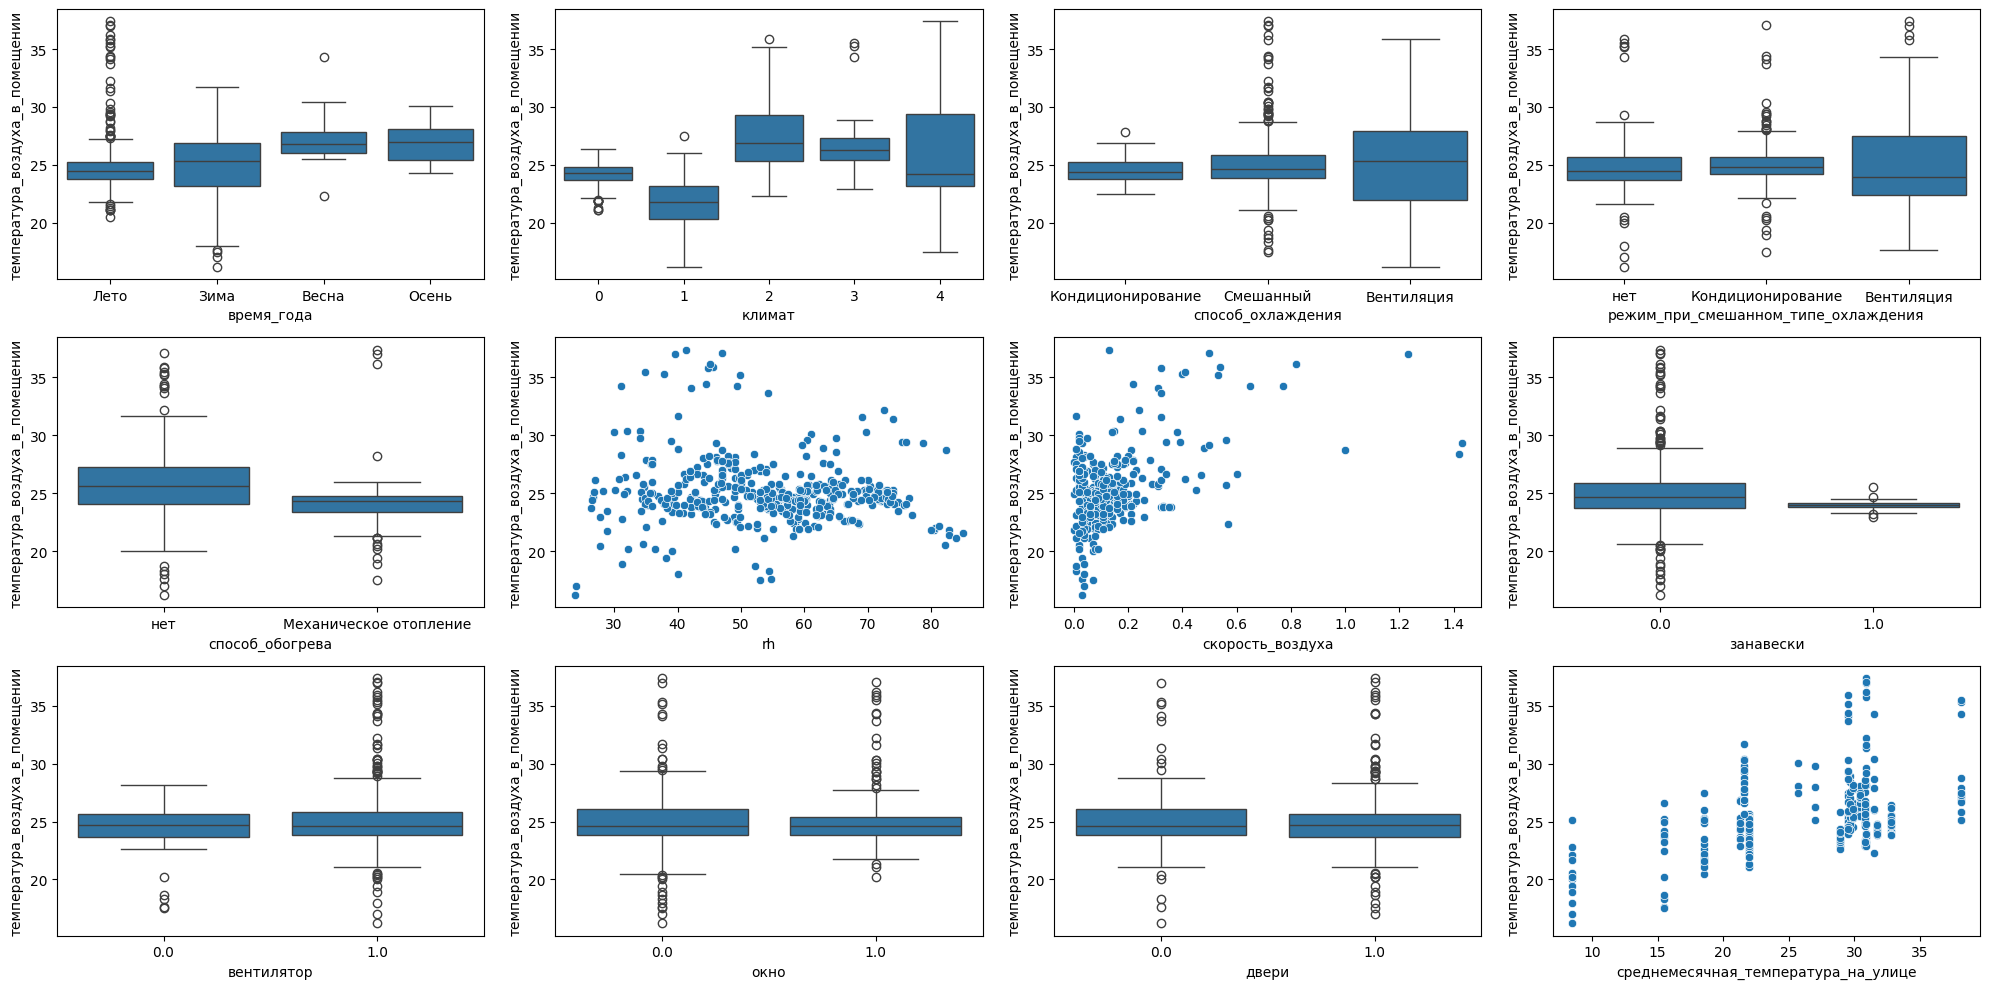

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=(20, 10))
i = 0
for col in factors.columns:
    if col != 'температура_воздуха_в_помещении':
        get_plot(factors[col], df['температура_воздуха_в_помещении'], types[col], types['температура_воздуха_в_помещении'], i // 4, i % 4)
        i += 1
fig.tight_layout()

In [ ]:
res = []
f2 = 'температура_воздуха_в_помещении'
for i in range(len(factors_list)):
    f1 = factors_list[i]
    if f1 != f2:
        res.append([*correlation(factors[f1], factors[f2], types[f1], types[f2]), f1])
res.sort(key=lambda x: x[1] if x[1] < 0.05 else 1e9, reverse=False)
res

[[182.0219169567037, 2.743358059798561e-38, 1, 'климат'],
 [0.42179035551304545,
  4.718815884032914e-21,
  5,
  'среднемесячная_температура_на_улице'],
 [37698.0, 2.9537861270668604e-17, 0, 'способ_обогрева'],
 [36.66660650218179, 5.412737559554017e-08, 1, 'время_года'],
 [0.21627819420018726, 3.225685409526806e-06, 5, 'скорость_воздуха'],
 [3154.5, 0.0012914470540354307, 0, 'занавески'],
 [10.914894905080471,
  0.004264427016542392,
  1,
  'режим_при_смешанном_типе_охлаждения'],
 [-0.10508359632844205, 0.024990261116553867, 5, 'rh'],
 [3.0997698469121837, 0.2122723999954351, 1, 'способ_охлаждения'],
 [11065.0, 0.7934141651624057, 0, 'вентилятор'],
 [24187.0, 0.911866619920265, 0, 'окно'],
 [26239.5, 0.7912730284858436, 0, 'двери']]

In [ ]:
# выделяем те факторы, влияние которых наибольшее
x = df[['время_года', 'климат', 'способ_обогрева', 'среднемесячная_температура_на_улице', 'вентилятор', 'скорость_воздуха']]
y = df['температура_воздуха_в_помещении']

In [ ]:
# применяем энкодинг к категориальным столбцам
for col in x.columns:
    if x[col].dtype not in ['float', 'int']:
        enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        x[(col + ': ' + x[col].unique()).tolist()] = enc.fit_transform(x[[col]])
        x.drop(col, axis=1, inplace=True)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [ ]:
# строим модель и проверяем её эффективность
reg = LinearRegression()
reg.fit(x_train, y_train)
reg.score(x_test, y_test)

0.6486053901517747

In [ ]:
mse(y_test, reg.predict(x_test)) ** 0.5

1.8124064203743933

In [ ]:
# сохраняем модель
from joblib import dump, load
dump(reg, 'models/regressor_without_temp.joblib')

['models/regressor_without_temp.joblib']

In [ ]:
# загружаем модель
reg = load('models/regressor_without_temp.joblib')

df.to_csv('corrected_data.csv')
